# Stateful Optimizer

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

from stateless_optim import *

In [3]:
#export
def momentum_step(param, learning_rate, avg_grad, **kwargs):
    '''Momentum Stepping Function.
        param: model parameters
        learning_rate: step size of each training iteration
        avg_grad: momentum weighted average gradient
        kwargs: umbrella for preventing parameter error
    '''
    param.data -= learning_rate * avg_grad

In [4]:
#export
class StatefulOpt():
    def __init__(self, params, steppers=None, stats=None, **hyper_params):
        '''Improved StatelessOpt by allowing past hyperparameters values to be stored in states.
            params: model parameters
            steppers: list of stepper functions
            stats: internal optimizer stats (ex. average gradient of parameters)
            hyper_params: hyper parameters to keep track of
        '''
        self.params = [params] if isinstance(params, list) else [[params]]
        self.steppers = steppers if steppers != None else [sgd_step]
        self.stats = stats if stats != None else []
        self.state = {}
        self.hypers = [dict(hyper_params) for p in self.params]

    def _grad_params(self):
        return [(p, h) for ps, h in zip(self.params, self.hypers) for p in ps if p.grad != None]
    
    def step(self):
        for p, hps in self._grad_params():
            if p not in self.state:
                self.state[p] = {}
                for stat in self.stats:
                    self.state[p].update(stat.init_state(p).items())
            # update individual stat states
            p_state = self.state[p]
            for stat in self.stats:
                p_state = stat.update_state(p, p_state, **hps)
            # step
            compose_inplace(p, self.steppers, **p_state, **hps)
            self.state[p] = p_state

    def zero_grad(self):
        for hps in self.params: 
            for hp in hps:
                hp.zero_grad()

    def __repr__(self):
        return f'(StatefulOpt) steppers: {[stepper.__name__ for stepper in self.steppers]}, stats: {[stat.__class__.__name__ for stat in self.stats]}'

In [5]:
#export
class Stat():
    def __init__(self):
        '''Class for keeping track of measurement.'''
        pass
    
    def init_state(self, param): 
        raise NotImplementedError('Stat.init_state')
        
    def update_state(self, param, state, **kwargs): 
        raise NotImplementedError('Stat.update')

class WeightedSumGrad(Stat):
    def __init__(self):
        '''Weighted gradient measurement.'''
        pass
    
    def init_state(self, param):
        return {'avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, mom, **kwargs):
        state['avg_grad'] = weighted_sum(state['avg_grad'], param.grad, mom)
        return state

In [6]:
#export
class StepCount(Stat):
    def __init__(self):
        '''Simple measurement to keep track of how many updates were done.'''
        pass
    
    def init_state(self,p): 
        return {'step': 0}
    
    def update_state(self, p, state, **kwargs):
        state['step'] += 1
        return state

class ExpWeightedGrad(Stat):
    def __init__(self, dampening=False): 
        '''Exponentially weighted moving avg of gradient.
            dampening: dampening coefficient
        '''
        self.dampening = dampening
    
    def init_state(self, param): 
        return {'avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, mom, **kwargs):
        state['damp_mom'] = 1. - mom if self.dampening else 1. 
        state['avg_grad'].mul_(mom).add_(state['damp_mom'], param.grad.data)
        return state

class ExpWeightedSqrGrad(Stat):
    def __init__(self, dampening=True):
        '''Exponentially weighted moving avg of squared gradient.
            dampening: dampening coefficient
        '''
        self.dampening = dampening
    
    def init_state(self, param): 
        return {'sqr_avg_grad': torch.zeros_like(param.grad.data)}
    
    def update_state(self, param, state, sqr_mom, **kwargs):
        state['sqr_damp_mom'] = 1. - sqr_mom if self.dampening else 1. 
        state['sqr_avg_grad'].mul_(sqr_mom).addcmul_(state['sqr_damp_mom'], param.grad.data, param.grad.data)
        return state

In [7]:
#export
def debias(mom, damp, step): 
    '''Util function to compute the debias coefficient for adam optimizer.
        mom: momentum
        damp: dampening coefficient
        step: number of past optimizer steps
    '''
    return damp * (1. - mom**step) / (1. - mom)

def adam(param, learning_rate, mom, damp_mom, step, sqr_mom, sqr_damp_mom, avg_grad, sqr_avg_grad, eps=1e-5, **kwargs):
    '''Adam optimizer stepper (for details: https://arxiv.org/abs/1412.6980).
        param: model parameters
        learning_rate: step size of each training iteration 
        mom: momentum for avg
        damp_mom: damping parameter for mom
        step: number of steps taken by optimizer
        sqr_mom: momentum for sqr avg grad
        sqr_damp_mom: damping parameter for sqr_mom
        avg_grad: average (momentum weighted) past gradient of parameter
        sqr_avg_grad: average (momentum weight) past squared gradient of parameter
        eps: small epsilon value to prevent gradient explosion
        kwargs: other optimizer internal variables
    '''
    debias1 = debias(mom,     damp_mom,     step)
    debias2 = debias(sqr_mom, sqr_damp_mom, step)
    param.data.addcdiv_(-learning_rate/debias1, avg_grad, (sqr_avg_grad/debias2).sqrt() + eps)    
    return param

def adam_opt(model, beta1=0.9, beta2=0.99, **kwargs):
    '''Util function to get adam optimizer.
        model: training model
        beta1: adam weighting coefficient (https://arxiv.org/abs/1412.6980)
        beta2: adam weight coefficient
        kwargs: other optimizer internal variables
    '''
    return StatefulOpt(list(model.parameters()), [adam, l2_reg], 
                       [ExpWeightedGrad(True), ExpWeightedSqrGrad(), StepCount()],
                       mom=beta1, sqr_mom=beta2, **kwargs)

In [8]:
#export
def lamb_step(param, learning_rate, mom, damp_mom, step, sqr_mom, sqr_damp_mom, avg_grad, sqr_avg_grad, weight_decay, eps=1e-5, **kwargs):
    '''LAMB optimizer stepper (https://arxiv.org/abs/1904.00962).
        param: model parameters
        learning_rate: step size of each training iteration 
        mom: momentum for avg
        damp_mom: damping parameter for mom
        step: number of steps taken by optimizer
        sqr_mom: momentum for sqr avg grad
        sqr_damp_mom: damping parameter for sqr_mom
        avg_grad: average (momentum weighted) past gradient of parameter
        sqr_avg_grad: average (momentum weight) past squared gradient of parameter
        weight_decay: weight decay parameter (from L2 regularization)
        eps: small epsilon value to prevent gradient explosion
        kwargs: other optimizer internal variables
    '''
    debias1 = debias(mom,     damp_mom,     step)
    debias2 = debias(sqr_mom, sqr_damp_mom, step)
    r1 = param.data.pow(2).mean().sqrt()
    step = (avg_grad/debias1) / ((sqr_avg_grad/debias2).sqrt() + eps) + weight_decay*param.data
    r2 = step.pow(2).mean().sqrt()
    param.data.add_(-learning_rate * min(r1/r2, 10), step)
    return param

def lamb_opt(model, beta1=0.9, beta2=0.99, **kwargs):
    '''Util function to get LAMB optimizer.
        model: training model
        beta1: adam/lamb weighting coefficient (https://arxiv.org/abs/1904.00962)
        beta2: adam/lamb weight coefficient
        kwargs: other optimizer internal variables
    '''
    return StatefulOpt(list(model.parameters()), [lamb_step], 
                       [ExpWeightedGrad(True), ExpWeightedSqrGrad(), StepCount()],
                       mom=beta1, sqr_mom=beta2, **kwargs)

# Tests

### Try Momentum + Weight Decay

In [9]:
hyper_params = {'weight_decay':1e-4, 'learning_rate':0.001, 'mom':0.9}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.01, 0.5, 0.01))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = StatefulOpt(list(model.parameters()), steppers=[l2_reg, sgd], stats=[WeightedSumGrad()], **hyper_params)
loss_fn = CrossEntropy()
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['l2_reg', 'sgd'], stats: ['WeightedSumGrad']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging']


In [10]:
learner.fit(5)

Epoch - 1
train metrics - [6.552619934082031e-06, 0.88566]
valid metrics - [1.381521224975586e-05, 0.9671]

Epoch - 2
train metrics - [9.963397979736329e-06, 0.95706]
valid metrics - [5.904483795166016e-06, 0.9701]

Epoch - 3
train metrics - [1.5966796875e-06, 0.96494]
valid metrics - [8.393526077270507e-06, 0.9706]

Epoch - 4
train metrics - [6.601524353027343e-07, 0.96938]
valid metrics - [4.822874069213867e-06, 0.9721]

Epoch - 5
train metrics - [4.314746856689453e-06, 0.97248]
valid metrics - [2.9812812805175782e-06, 0.9733]



### Try Adam + Weight Decay

In [11]:
hyper_params = {'learning_rate':0.001, 'weight_decay':1e-4}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.0001, 0.003, 0.0001))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
loss_fn = CrossEntropy()
optimizer = adam_opt(model, **hyper_params)
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging(), Recorder()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['adam', 'l2_reg'], stats: ['ExpWeightedGrad', 'ExpWeightedSqrGrad', 'StepCount']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging', 'Recorder']


In [12]:
learner.fit(5)

Epoch - 1
train metrics - [3.6572084426879884e-05, 0.87352]
valid metrics - [3.810768127441406e-05, 0.9612]

Epoch - 2
train metrics - [0.0001840702819824219, 0.95648]
valid metrics - [1.5598678588867188e-05, 0.9685]

Epoch - 3
train metrics - [6.798868179321289e-06, 0.96584]
valid metrics - [1.335439682006836e-05, 0.9727]

Epoch - 4
train metrics - [1.4617090225219727e-05, 0.97108]
valid metrics - [4.605817794799805e-06, 0.9729]

Epoch - 5
train metrics - [9.759483337402344e-06, 0.97552]
valid metrics - [8.419322967529297e-06, 0.9741]



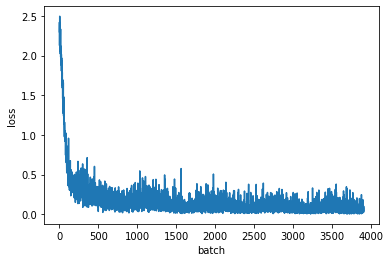

In [13]:
learner.callbacks[3].plot_losses()

### Try LAMB

In [14]:
hyper_params = {'weight_decay':1e-4, 'learning_rate':0.001}
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(0.0001, 0.003, 0.0001))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
loss_fn = CrossEntropy()
optimizer = lamb_opt(model, **hyper_params)
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging(), Recorder()]

learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(StatefulOpt) steppers: ['lamb_step'], stats: ['ExpWeightedGrad', 'ExpWeightedSqrGrad', 'StepCount']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging', 'Recorder']


In [15]:
learner.fit(5)

Epoch - 1
train metrics - [8.129660606384278e-05, 0.7509]
valid metrics - [7.845478057861328e-05, 0.9428]

Epoch - 2
train metrics - [1.619072914123535e-05, 0.94102]
valid metrics - [5.07824182510376e-05, 0.9598]

Epoch - 3
train metrics - [1.035010814666748e-05, 0.9571]
valid metrics - [3.7328767776489255e-05, 0.966]

Epoch - 4
train metrics - [6.60390853881836e-07, 0.96486]
valid metrics - [2.0715856552124023e-05, 0.9691]

Epoch - 5
train metrics - [9.757254600524902e-05, 0.96948]
valid metrics - [1.620779037475586e-05, 0.9702]



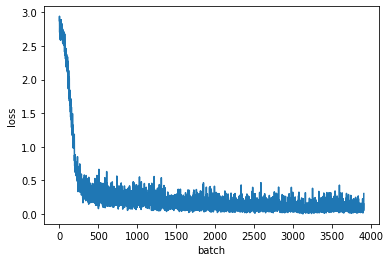

In [16]:
learner.callbacks[3].plot_losses()